**ÉTAPE 0** : préparation des données

In [1]:
import process 
import pandas as pd
import numpy as np

# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
# Jerome path : 'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DATA_Statapp.csv'
# Mohamed path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv')

# Apply conversion function to 'open' and 'close' columns
df['open'] = df['open'].apply(process.safe_literal_eval)
df['close'] = df['close'].apply(process.safe_literal_eval)

# Calculate returns for each line
df['return'] = df.apply(lambda row: [(close - open) / open for open, close in zip(row['open'], row['close'])], axis=1)

new_df = df[['ticker', 'return']] # create a new data frame with the column ticker and return 

# Créons le DataFrame à partir des listes dans 'return'
# On suppose ici que 'new_df' est déjà défini et contient la colonne 'return'

# Convertir chaque liste dans la colonne 'return' en plusieurs colonnes dans le nouveau DataFrame
returns_df = pd.DataFrame(new_df['return'].tolist())

# Ajouter la colonne 'ticker' du 'new_df' au début de 'returns_df'
returns_df.insert(0, 'ticker', new_df['ticker'])

# Renommer les colonnes pour refléter qu'elles sont des rendements
returns_df.columns = ['ticker'] + [f'return_{i}' for i in range(len(returns_df.columns) - 1)]

df_cleaned = process.remove_rows_with_nan(returns_df)
df_cleaned.reset_index(drop=True, inplace=True)

process.check_nan_inf(df_cleaned)

df_cleaned.set_index('ticker', inplace=True)

There are no NaN values in the dataframe


In [11]:
lookback_window = 250
number_of_clusters = 20
sigma = 10 
 


correlation_matrix = process.correlation_matrix(lookback_window=lookback_window, df_cleaned=df_cleaned)
cluster_composition_and_centroid = process.cluster_composition_and_centroid(df_cleaned, correlation_matrix, number_of_clusters, lookback_window)

/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  A_pos = mat.applymap(lambda x: x if x >= 0 else 0)
/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  A_neg = mat.applymap(lambda x: abs(x) if x < 0 else 0)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
constituent_weights = process.constituent_weights(df_cleaned=df_cleaned, cluster_composition=cluster_composition_and_centroid, sigma=10, lookback_window=lookback_window)

In [13]:
df.set_index('ticker', inplace=True)

In [59]:
open = pd.DataFrame(index = df_cleaned.index, columns=df_cleaned.columns[:lookback_window+1])
close = pd.DataFrame(index = df_cleaned.index, columns=df_cleaned.columns[:lookback_window+1])

cluster_open_and_close = pd.DataFrame(index = [f'cluster {i+1}' for i in range(len(constituent_weights))], columns = df_cleaned.columns[:lookback_window+1])

open = pd.DataFrame(index = df_cleaned.index, columns=df_cleaned.columns)
close = pd.DataFrame(index = df_cleaned.index, columns=df_cleaned.columns)

for stock in open.index:
    open.loc[stock, :] = df.loc[stock, 'open']
    close.loc[stock, :] = df.loc[stock, 'close']

In [60]:
for returns in cluster_open_and_close.columns:

    for elem in constituent_weights:
        op, cl = 0, 0
        for stocks in elem[1]:
            op += open.loc[stocks[0], returns]*stocks[1]
            cl += close.loc[stocks[0], returns]*stocks[1]

        cluster_open_and_close.loc[elem[0], returns] = (cl - op)/op
        

In [61]:
cluster_open_and_close

,return_0,return_1,return_2,return_3,return_4,return_5,return_6,return_7,return_8,return_9,...,return_241,return_242,return_243,return_244,return_245,return_246,return_247,return_248,return_249,return_250
cluster 1,-0.025523,-0.014074,0.011274,0.016238,0.014507,-0.004658,-0.007976,-0.002599,0.005463,-0.00472,...,-0.013008,-0.003613,0.015514,-0.000471,-0.014712,0.017306,0.019233,0.009676,0.021464,0.020635
cluster 2,-0.018786,-0.017554,0.010958,0.007844,0.016103,0.002628,-0.003377,-0.005781,0.006298,-0.00257,...,-0.007947,0.002469,0.007862,-0.000899,-0.010099,0.008788,0.020507,0.010368,0.026002,0.019999
cluster 3,-0.031324,0.002887,0.013959,0.0369,0.018435,-0.010162,0.008103,-0.014295,0.024188,0.004394,...,-0.026714,0.016329,0.040943,0.013686,-0.018072,0.008278,0.011742,0.052216,0.004166,0.017034
cluster 4,-0.007733,-0.013057,0.008856,0.018391,0.035083,-0.017969,0.009044,0.00047,0.001052,-0.010771,...,0.005572,0.001081,0.00678,0.011011,0.005065,0.004542,-0.005505,0.018089,0.011778,0.008934
cluster 5,0.001797,0.004802,0.001195,0.008378,0.002969,0.002966,-0.007117,0.001201,0.003632,-0.006619,...,0.005122,0.012464,0.020157,-0.006041,-0.002767,-0.008894,0.003921,0.003913,0.005565,0.0
cluster 6,0.019355,0.0,0.009464,0.006231,0.006211,0.0,0.009259,0.006079,0.009063,-0.00597,...,-0.009009,0.012158,-0.015015,-0.009063,-0.012048,0.009119,0.012158,0.009009,0.002985,-0.005952
cluster 7,-0.024209,0.01249,0.031347,0.003542,0.008218,-0.00731,-0.001596,0.010761,0.001572,-0.004642,...,-0.011653,0.004652,0.010383,0.003939,0.018034,0.000189,0.008901,0.022613,-0.000123,0.003444
cluster 8,0.001126,0.023483,0.005478,0.009762,0.006421,0.003179,0.001049,-0.002102,-0.003159,-0.001055,...,0.028945,0.002028,0.010202,0.001322,-0.013375,0.004744,-0.006705,0.012186,-0.007117,0.01138
cluster 9,-0.010887,-0.029764,-0.003593,-0.022229,0.035779,0.016098,-0.018957,-0.008748,0.014685,0.004983,...,-0.017786,-0.009735,-0.012713,-0.009859,-0.024495,-0.004758,0.028013,-0.005404,0.020489,0.026454
cluster 10,0.007767,0.009634,-0.003795,0.003802,0.003795,-0.0,-0.003788,-0.001905,0.001916,0.007634,...,0.007505,0.007519,0.005587,-0.001855,0.005587,0.012915,0.0,-0.001841,-0.003663,0.003676


In [54]:
open

,return_0,return_1,return_2,return_3,return_4,return_5,return_6,return_7,return_8,return_9,...,return_5521,return_5522,return_5523,return_5524,return_5525,return_5526,return_5527,return_5528,return_5529,return_5530
ticker,,,,,,,,,,,,,,,,,,,,,
AA,82.0,80.5,82.0,85.875,86.0,87.125,82.0,83.5625,83.125,81.625,...,52.26,51.89,53.8,56.93,59.0,58.37,59.28,59.13,59.68,59.16
ABM,20.5,20.125,20.25,20.1875,20.1875,20.25,20.25,19.9375,19.9375,20.0,...,40.95,39.8,39.2,40.33,41.0,41.41,41.17,40.9,40.62,40.59
ABT,35.25,34.4375,33.5625,34.0,34.5,36.0,34.375,34.8125,34.0625,34.5,...,137.53999,136.2,136.02,135.88,139.64999,139.82001,141.58,140.47,141.41,141.0
ADI,93.5,89.5,85.625,86.875,84.0,90.0,93.5,90.3125,95.75,95.75,...,171.12,166.83501,170.11501,171.64999,172.8,173.00999,176.42,174.53,176.0,174.75
ADM,12.0,11.8125,11.875,11.625,11.875,12.0,11.9375,11.8125,12.0,12.125,...,65.88,64.71,64.57,64.85,64.8,65.54,66.0,67.05,67.2,66.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XLY,31.0,29.6875,29.34375,29.04688,29.5,30.53125,30.5,30.3125,30.21875,30.25,...,194.99001,191.88,193.89999,197.46001,200.66,203.57001,205.63,205.75999,204.97,205.09
XOM,79.5,77.375,78.0,80.625,85.9375,84.1875,83.75,83.25,83.5,85.5,...,60.95,58.79,59.75,60.34,61.17,60.93,61.91,61.48,61.22,60.74
XRX,23.375,24.1875,23.0,23.5625,23.75,24.75,23.875,23.25,23.5,24.1875,...,20.57,20.1,20.51,21.33,21.97,22.35,22.73,23.04,23.12,22.74


In [41]:
elem = constituent_weights[0]
stocks = elem[1]
for stock in stocks:
    print(stock)

['AA', 0.9991760870177944]
['ADM', 0.9995029035552058]
['AIN', 0.999366214627061]
['AIR', 0.9983535821579772]
['ALB', 0.99926427304019]
['APD', 0.9993871612817845]
['ASH', 0.9996373256347612]
['ATR', 0.999243514753112]
['AVY', 0.9994008661849462]
['BA', 0.9993922183316332]
['BRC', 0.9992177710729807]
['CAT', 0.9995343974105357]
['CHD', 0.9991882096471663]
['CLX', 0.9990774034520864]
['CMC', 0.9996078407886994]
['CNI', 0.9995017328688671]
['CP', 0.9995534180987447]
['CRS', 0.999296902307264]
['DE', 0.9992548625289281]
['DHR', 0.9995590741506987]
['DOV', 0.9995595504888938]
['DRI', 0.9992567730732693]
['EAT', 0.999147212029938]
['ECL', 0.9996690952220574]
['EL', 0.9994053845977263]
['EMN', 0.9994974258920927]
['EMR', 0.9995832443077052]
['ETN', 0.9994278023560594]
['F', 0.999438166771801]
['FCX', 0.9987571001805247]
['FDX', 0.9994225799956172]
['FLS', 0.9992868823553134]
['FMC', 0.9997205892111282]
['GAB', 0.9998123718456836]
['GD', 0.9994708407184113]
['GE', 0.9995369413142592]
['GLT', 

In [34]:
cluster_open_and_close.loc['cluster 1', 'return_0']

nan

**ÉTAPE 1** : Phase d'entraînement et de construction (avec répétitions)

In [6]:
'''
--------------------------------------------------------------------------------------------------------------------
PARAMETERS
--------------------------------------------------------------------------------------------------------------------
'''
## sigma ? 

number_of_repetitions = 50
lookback_window = 250
number_of_clusters = 20
evaluation_window = 60
risk_free_rate = 0.04
clustering_method = 'signed_laplacian'


consolidated_W = process.consolidated_W(lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, number_of_repetitions=number_of_repetitions, clustering_method=clustering_method)

portfolio_return = process.portfolio_annualized_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, training_window=lookback_window, consolidated_W=consolidated_W)

SR, PNL = process.Sharpe_and_PnL(portfolio_annualized_returns=portfolio_return, risk_free_rate=risk_free_rate)


/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  A_pos = mat.applymap(lambda x: x if x >= 0 else 0)
/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  A_neg = mat.applymap(lambda x: abs(x) if x < 0 else 0)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Code/process.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  A_pos = mat.applymap(lambda x: x if x >= 0 else 0)
/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project

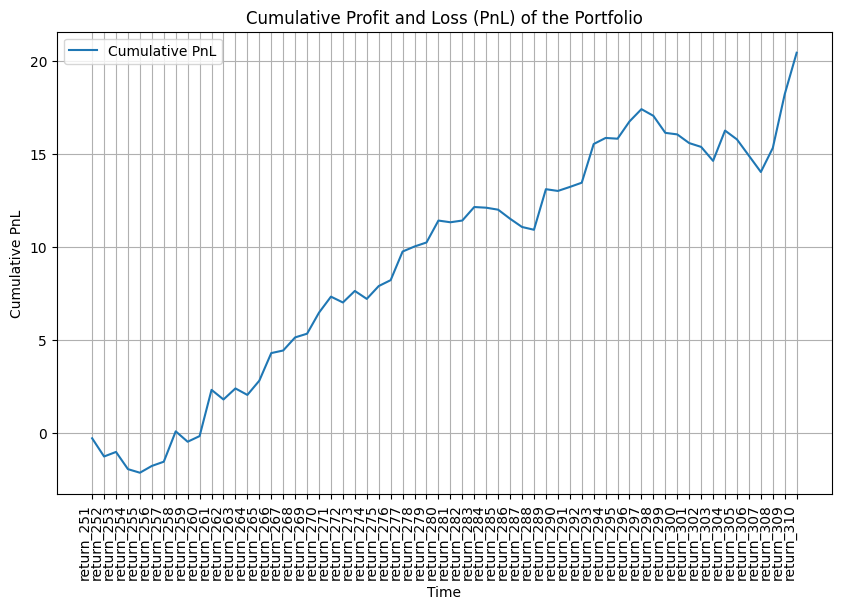

In [8]:
import matplotlib.pyplot as plt 

# Calcul du PnL cumulatif
cumulative_pnl = np.cumsum(portfolio_return)

# Tracé du PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(cumulative_pnl, label='Cumulative PnL')
plt.title('Cumulative Profit and Loss (PnL) of the Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)

plt.xticks(rotation=90, ha='right')

plt.show()



In [10]:
sharpe_ratio = np.mean(portfolio_return) / np.std(portfolio_return)
print(sharpe_ratio)
print(cumulative_pnl)

portfolio annualized return    0.379089
dtype: float64
            portfolio annualized return
return_251                    -0.278482
return_252                    -1.256410
return_253                    -1.011412
return_254                    -1.935620
return_255                    -2.127529
return_256                    -1.763100
return_257                    -1.536514
return_258                     0.094010
return_259                    -0.463423
return_260                    -0.160826
return_261                     2.321292
return_262                     1.804807
return_263                     2.397886
return_264                     2.049969
return_265                     2.814387
return_266                     4.295607
return_267                     4.434960
return_268                     5.137989
return_269                     5.336296
return_270                     6.468068
return_271                     7.326453
return_272                     7.012619
return_273               

/usr/local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [11]:
import plotly.graph_objects as go


process.plot_PnL(SR=SR, PNL=PNL)

In [13]:
list(df_cleaned.index)

['AA',
 'ABM',
 'ABT',
 'ADI',
 'ADM',
 'ADX',
 'AEE',
 'AEG',
 'AEM',
 'AEP',
 'AES',
 'AFG',
 'AFL',
 'AIG',
 'AIN',
 'AIR',
 'AIV',
 'AJG',
 'ALB',
 'ALK',
 'ALL',
 'ALV',
 'AMD',
 'AME',
 'AMG',
 'AMT',
 'AN',
 'ANF',
 'AOS',
 'APA',
 'APD',
 'APH',
 'ARE',
 'ARW',
 'ASA',
 'ASG',
 'ASGN',
 'ASH',
 'ATO',
 'ATR',
 'AU',
 'AVA',
 'AVB',
 'AVT',
 'AVY',
 'AWF',
 'AWR',
 'AXL',
 'AXP',
 'AZN',
 'AZO',
 'B',
 'BA',
 'BAC',
 'BAX',
 'BBY',
 'BC',
 'BCS',
 'BDN',
 'BDX',
 'BEN',
 'BF',
 'BFS',
 'BHE',
 'BHP',
 'BK',
 'BKE',
 'BKH',
 'BKN',
 'BKT',
 'BLK',
 'BLL',
 'BMO',
 'BMY',
 'BOH',
 'BPT',
 'BRC',
 'BRK',
 'BRO',
 'BSX',
 'BTI',
 'BTO',
 'BWA',
 'BXP',
 'BYD',
 'CAG',
 'CAT',
 'CB',
 'CBT',
 'CCK',
 'CDE',
 'CFR',
 'CHD',
 'CHH',
 'CHN',
 'CI',
 'CIA',
 'CIEN',
 'CIF',
 'CIK',
 'CL',
 'CLB',
 'CLF',
 'CLS',
 'CLX',
 'CMA',
 'CMC',
 'CMS',
 'CMU',
 'CNA',
 'CNI',
 'CNX',
 'COF',
 'COO',
 'CP',
 'CPB',
 'CPE',
 'CPK',
 'CPT',
 'CR',
 'CRD',
 'CRK',
 'CRS',
 'CRY',
 'CSL',
 'CSX',
 'CT